<a href="https://colab.research.google.com/github/justinwickelgren/data-science-class/blob/main/JustWickU8Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

In [ ]:
!pip install pymc-bart
!pip install preliz

In [3]:
import pymc_bart as pmb
import preliz as pz

# Real Estate Prices

This project uses a dataset of home attributes to predict the price per unit area. This is interesting to me because I am curious how much things like how old a home is or how close to transit it is will impact its value.

In [ ]:
!pip install ucimlrepo

In [5]:
from ucimlrepo import fetch_ucirepo
# url = "https://users.stat.ufl.edu/~winner/data/hazelnut_color.csv"
# real_estate = pd.read_csv(url)
real_estate = fetch_ucirepo(id=477)
X = real_estate.data.features
y = real_estate.data.targets

Now that I have the data, I have to add the variable I am predicting to the data because it only has the predictors in the main dataframe.

In [6]:
real_estate = X.join(y)
real_estate

,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1
...,...,...,...,...,...,...,...
409,2013.000,13.7,4082.01500,0,24.94155,121.50381,15.4
410,2012.667,5.6,90.45606,9,24.97433,121.54310,50.0
411,2013.250,18.8,390.96960,7,24.97923,121.53986,40.6
412,2013.000,8.1,104.81010,5,24.96674,121.54067,52.5


The following scatterplots show the relationship between each predictor and the home price. The strength of the relationship appears to vary from quite weak (transaction date, age) to stronger (distance to transit, number of convenience stores, latitude, longitude). However, I will just use all the variables because none of them appear to have a super strong correlation with the price, so I want to give the model the best chance possible.

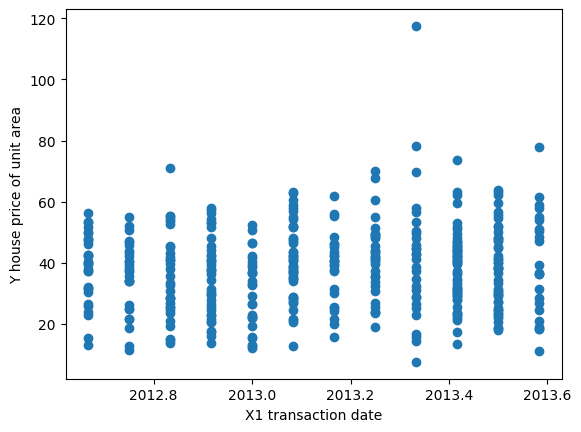

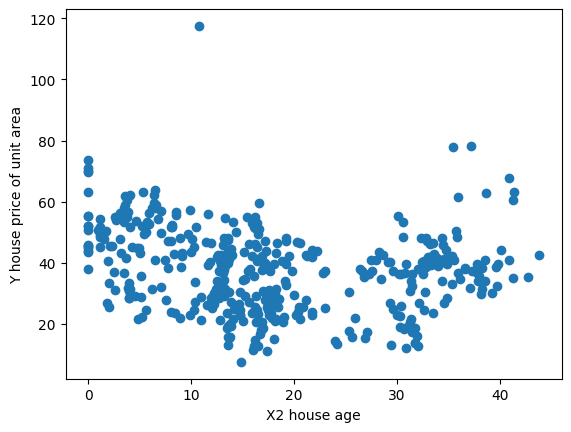

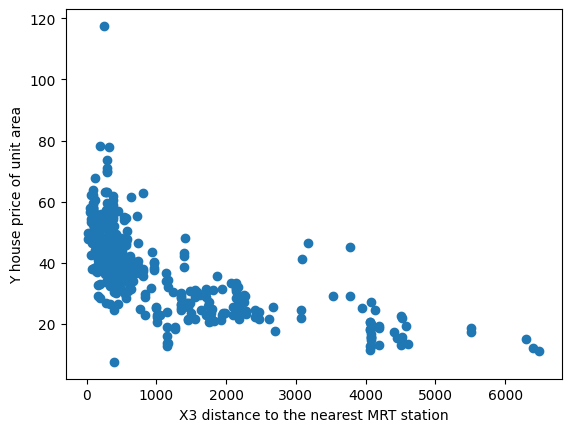

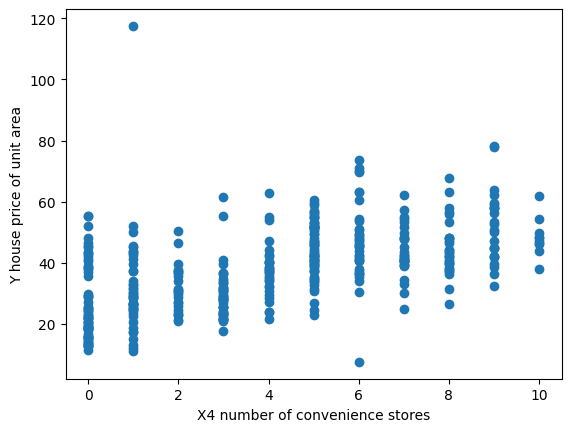

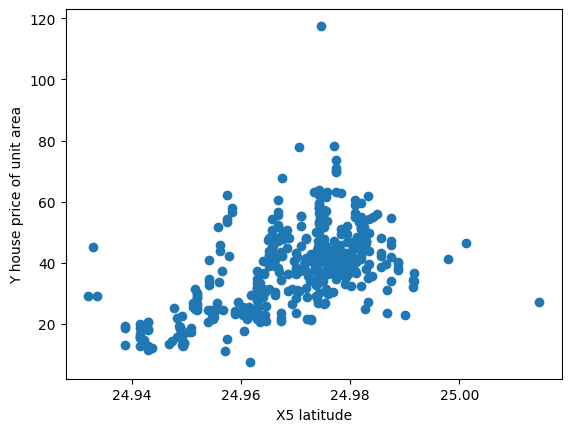

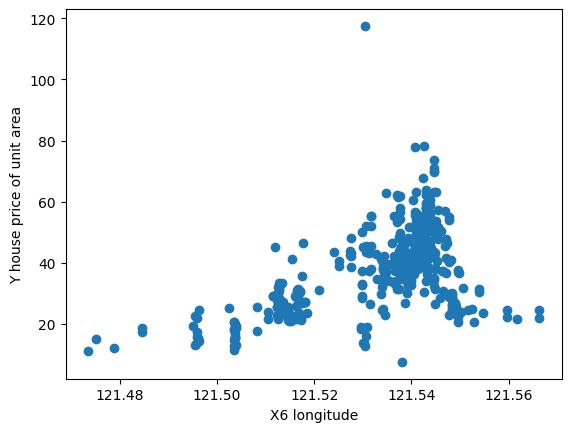

In [7]:
x = ["X1 transaction date", "X2 house age", "X3 distance to the nearest MRT station", "X4 number of convenience stores", "X5 latitude", "X6 longitude"]
y = "Y house price of unit area"
for a in x:
  plt.scatter(real_estate[a], real_estate[y])
  plt.xlabel(a)
  plt.ylabel(y)
  plt.show()

Output()

Output()

<Axes: xlabel='y'>

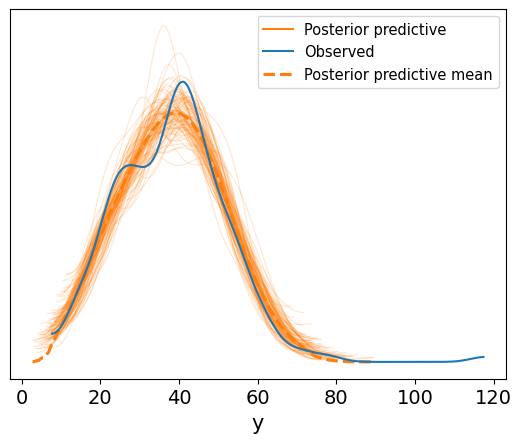

In [8]:
X = real_estate[x].to_numpy()
Y = real_estate[y].to_numpy()
with pm.Model() as model:
    s = pm.HalfNormal('s', 1000)
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50)
    μ = pm.Deterministic("μ", pm.math.exp(μ_))
    y = pm.Gamma("y", mu=μ, sigma=s,  observed=Y)
    idata = pm.sample(compute_convergence_checks=False)

pm.sample_posterior_predictive(idata, model, extend_inferencedata=True)
az.plot_ppc(idata, num_pp_samples=100, colors=["C1", "C0", "C1"])

This model shows the posterior predictive fitting the data quite well. Its primary flaw is the small dip around y=30, but I think this may be an anomaly in the data. I won't attempt to match it in my model because that could lead to overfitting, and the model is already quite good.

<Axes: ylabel='R²'>

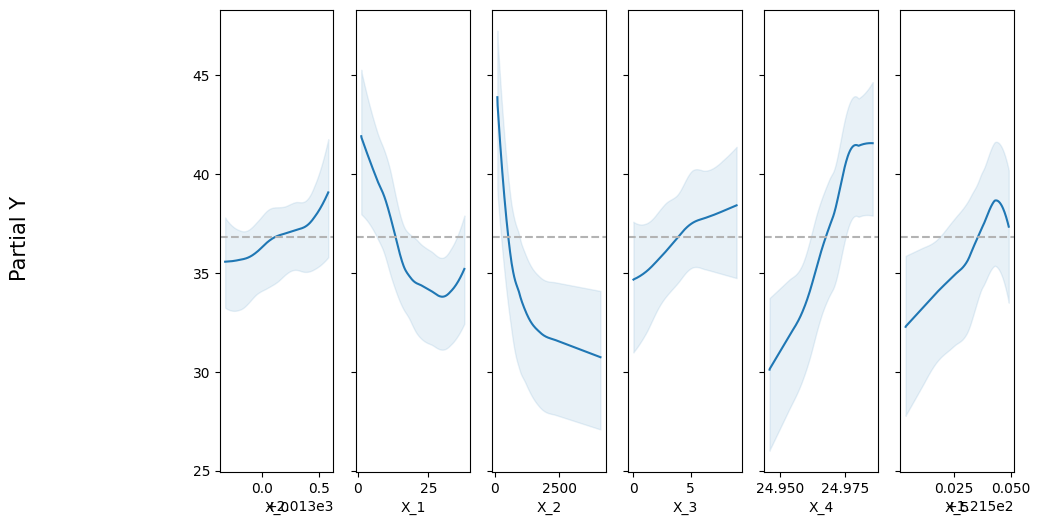

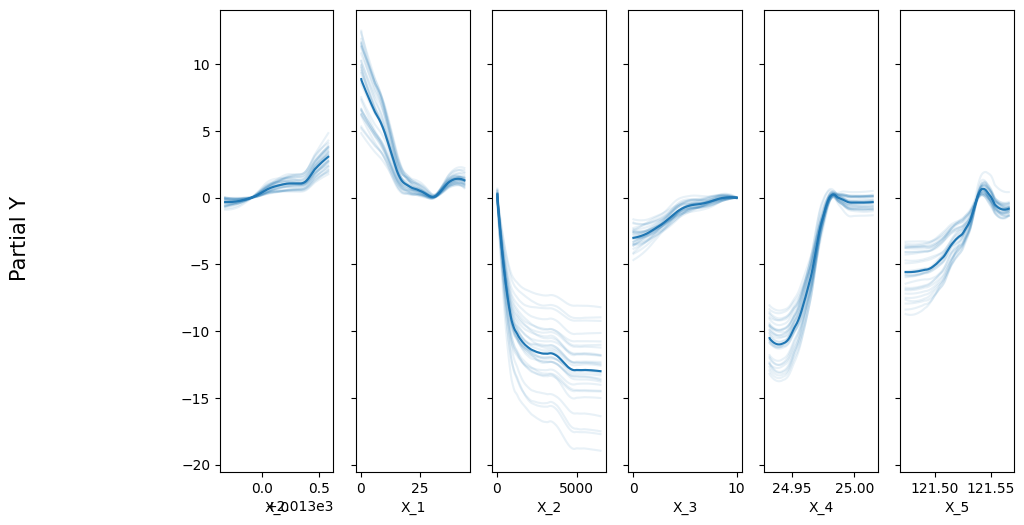

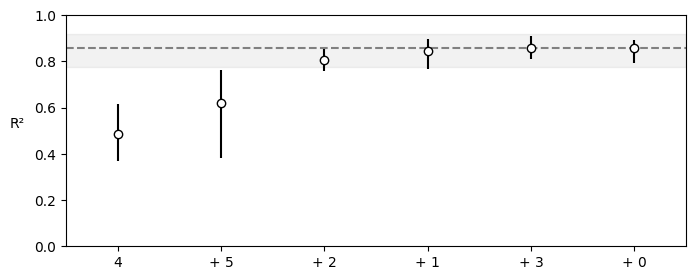

In [13]:
pmb.plot_pdp(μ_, X, Y, grid=(1, 7), func=np.exp, figsize = (12,6))
pmb.plot_ice(μ_, X, Y, grid=(1, 7), func=np.exp, figsize = (12,6))
vi = pmb.compute_variable_importance(idata, μ_, X)
pmb.plot_variable_importance(vi)

These plots suggest that most of our variables are improving the model because +3 is the best model. However, they aren't all necessary. Based on the partial dependence plots, I think that transaction date and convenience stores are likely the least valuable variables. We can confirm this by plotting posterior predictive over the data for each variable individually.

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


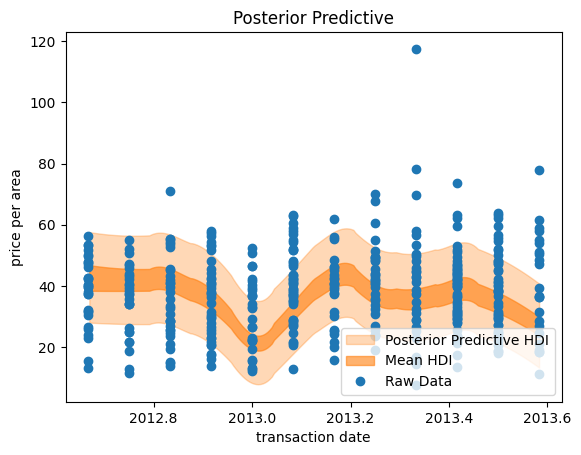

In [14]:
posterior_mean = idata.posterior["μ"]

μ_hdi = az.hdi(ary=idata, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idata, group="posterior_predictive", var_names=["y"]
).T


idx = np.argsort(X[:, 0])
fig, ax = plt.subplots()

az.plot_hdi(
    x=X[:, 0],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive HDI"},
)

az.plot_hdi(
    x=X[:, 0],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean HDI"},
)
ax.plot(real_estate["X1 transaction date"], real_estate["Y house price of unit area"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="transaction date",
    ylabel="price per area",
);

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


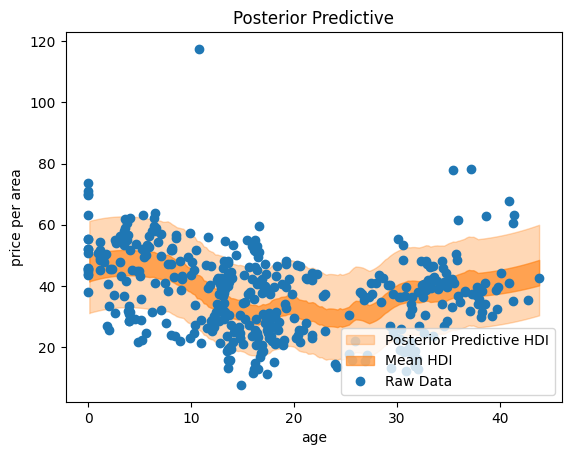

In [18]:
posterior_mean = idata.posterior["μ"]

μ_hdi = az.hdi(ary=idata, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idata, group="posterior_predictive", var_names=["y"]
).T


idx = np.argsort(X[:, 0])
fig, ax = plt.subplots()

az.plot_hdi(
    x=X[:, 1],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive HDI"},
)

az.plot_hdi(
    x=X[:, 1],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean HDI"},
)
ax.plot(real_estate["X2 house age"], real_estate["Y house price of unit area"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="age",
    ylabel="price per area",
);

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


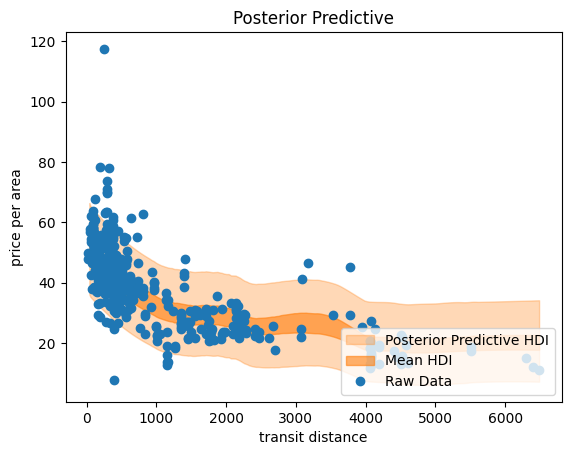

In [19]:
posterior_mean = idata.posterior["μ"]

μ_hdi = az.hdi(ary=idata, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idata, group="posterior_predictive", var_names=["y"]
).T


idx = np.argsort(X[:, 0])
fig, ax = plt.subplots()

az.plot_hdi(
    x=X[:, 2],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive HDI"},
)

az.plot_hdi(
    x=X[:, 2],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean HDI"},
)
ax.plot(real_estate["X3 distance to the nearest MRT station"], real_estate["Y house price of unit area"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="transit distance",
    ylabel="price per area",
);

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


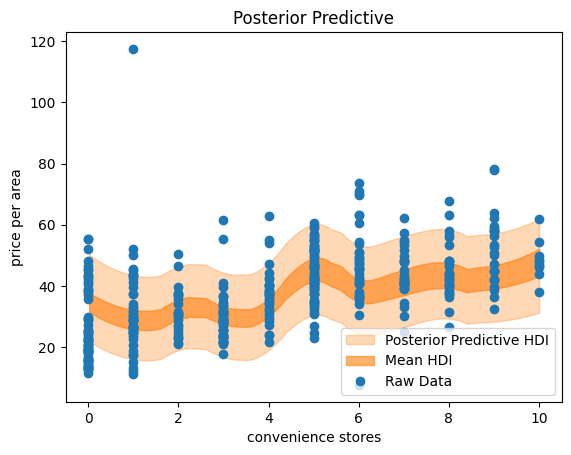

In [20]:
posterior_mean = idata.posterior["μ"]

μ_hdi = az.hdi(ary=idata, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idata, group="posterior_predictive", var_names=["y"]
).T


idx = np.argsort(X[:, 0])
fig, ax = plt.subplots()

az.plot_hdi(
    x=X[:, 3],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive HDI"},
)

az.plot_hdi(
    x=X[:, 3],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean HDI"},
)
ax.plot(real_estate["X4 number of convenience stores"], real_estate["Y house price of unit area"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="convenience stores",
    ylabel="price per area",
);

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


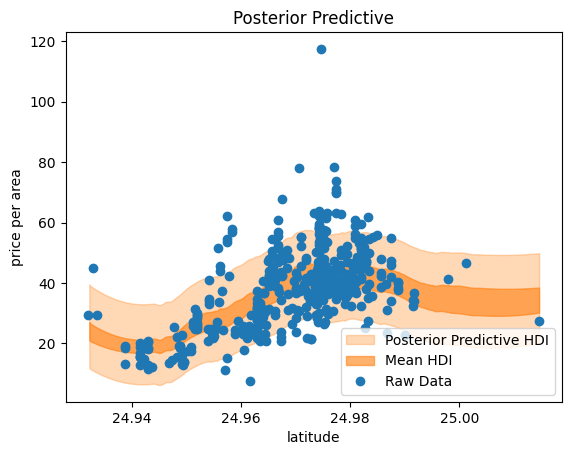

In [21]:
posterior_mean = idata.posterior["μ"]

μ_hdi = az.hdi(ary=idata, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idata, group="posterior_predictive", var_names=["y"]
).T


idx = np.argsort(X[:, 0])
fig, ax = plt.subplots()

az.plot_hdi(
    x=X[:, 4],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive HDI"},
)

az.plot_hdi(
    x=X[:, 4],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean HDI"},
)
ax.plot(real_estate["X5 latitude"], real_estate["Y house price of unit area"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="latitude",
    ylabel="price per area",
);

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


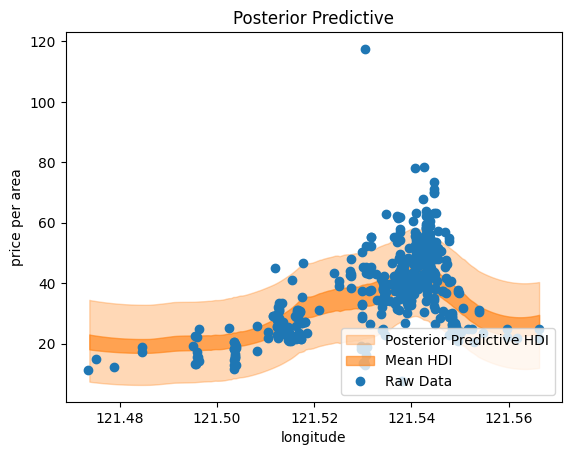

In [22]:
posterior_mean = idata.posterior["μ"]

μ_hdi = az.hdi(ary=idata, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idata, group="posterior_predictive", var_names=["y"]
).T


idx = np.argsort(X[:, 0])
fig, ax = plt.subplots()

az.plot_hdi(
    x=X[:, 5],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive HDI"},
)

az.plot_hdi(
    x=X[:, 5],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean HDI"},
)
ax.plot(real_estate["X6 longitude"], real_estate["Y house price of unit area"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="longitude",
    ylabel="price per area",
);

Because the data for transaction date and convenience stores is mostly flat, they are probably not adding much to the model. This could be because the data is discrete for these two variables, so it is harder for the model to find a pattern with less variation in the x values. However, the overall model is still fairly good, so I won't remove these variables.

In [23]:
from ipywidgets import Widget
Widget.close_all()